In [269]:
from data_collection import labelize,read_img,rescale
import pandas as pd
import os
from skimage import morphology as mor
import glob
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

In [191]:
def labelize(img_dir, BCS, Weight, save_path):
    labels = []
    weight = []
    image_names = []
    path_list=os.listdir(img_dir)

    for cow_img in path_list:
        for ID in BCS.Cow_ID:
            if str(ID) in cow_img:
                #here adapt the code to fill the labels you defined yourself
                labels.append(float(BCS.BCS_average[BCS.Cow_ID == ID]))
                image_names.append(cow_img)
                weight.append(int(Weight.Weight[Weight.Cow_ID == ID]))
    Results = pd.DataFrame({'image_names':image_names, 'BCS':labels, 'weight':weight})

    Results.to_csv(save_path,index=False)
    
    return Results

In [199]:
def baseline(form, baseline_dir, replace, disk):
    
    data = pd.DataFrame({'image_names':form.image_names,'BCS':form.BCS,'weight':form.weight,'angularity':[0]*len(form)})
    img_path = os.path.join(baseline_dir,'*.png')
    
    for i, cow_img  in enumerate(glob.glob(img_path)):
        cow = read_img(cow_img)
        #cow = rescale(cow)
        ball_roll = mor.opening(cow,disk)
        diff = cow-ball_roll
        diff_pd = pd.DataFrame(diff)
        
        diff_pd[diff_pd>1000] = replace
         
        angularity = np.sum(diff)/np.sum(cow)
        data.angularity.iloc[i] = angularity
        

        
    return diff, data

In [200]:
def fit(X,Y):
    #these are different linear models using only angularity as the attribute
    #Z = np.polyfit(X,Y,1)
    #Z = np.polyfit(X,Y,2)
    
    #adding weight variable
    poly = PolynomialFeatures(2)
    X1 = poly.fit_transform(X)
    Z = LinearRegression(normalize=False,fit_intercept=True).fit(X1,Y)
    return Z.coef_,Z.intercept_

In [201]:
def ang_BCS(angular,weight,Z):
    #BCS = Z[0]*angular*angular + Z[1]*angular +Z[2]
    #BCS = Z[0]*angular + Z[1]
    
    
    #transform inputs to 1, x1, x2, x1^2, x1x2, x2^:
    poly = PolynomialFeatures(2)
    X = np.c_[angular,weight]
    X = poly.fit_transform(X)
    BCS = np.dot(X,Z[0])+Z[1]
    BCS = BCS[0]
    #W = weight/100
    

    return BCS

In [202]:
def rolling_ball(test_dir,BCS_data,Weight_data,Z,disk,replace,err_range):
    
    angularities = []
    BCSs = []
    labels = []
    round_BCSs = []
    round_labels = []

    IDs = []
    errors = []
    weights = []

    im_path = os.path.join(test_dir, '*.png')
    
    for i, cow_img in enumerate(glob.glob(im_path)):
        
        cow = read_img(cow_img)
        ball_roll = mor.opening(cow,disk)
        diff =  cow - ball_roll
        diff_pd = pd.DataFrame(diff)
        diff_pd[diff_pd>1000] = replace
        
        angularity = np.sum(diff)/np.sum(cow)
        
        

    
        for ID in BCS_data.Cow_ID:
            if str(ID) in cow_img:
                #add weight as a factor
                weight = float(Weight_data.Weight[Weight_data.Cow_ID == ID])
                W = weight/1000
                A = angularity*1000
                BCS_res = ang_BCS(A, W, Z)
                
                BCS = format(BCS_res,'.3f')
                round_BCS = round(float(BCS)*4)/4
                
                labels.append(float(BCS_data.BCS_average[BCS_data.Cow_ID == ID]))
                weights.append(weight)
                round_labels.append(round(float(BCS_data.BCS_average[BCS_data.Cow_ID == ID])*4)/4)
                IDs.append(ID)
                
    
        angularities.append(angularity)
        BCSs.append(BCS)
        round_BCSs.append(round_BCS)
        
    BCSs = np.array(BCSs,float)
    labels = np.array(labels,float)
    errors = BCSs - labels
    average_error = np.sum(np.abs(errors))/len(errors)
    qualify = np.count_nonzero(np.abs(errors) < err_range)/len(errors)
    Results = pd.DataFrame({'cow_ID':IDs, 'weight':weights,'angularity':angularities,'label':labels,'estimated_BCS':BCSs,'errors':errors,'round_labels':round_labels,'round_BCS':round_BCSs})
    
    return average_error, qualify, Results

In [203]:
#baseline calculation
baseline_directory = 'C:/Users/BOZ/Zoetis_BCS/BCS_estimation/3D_rolling_ball/baseline/'
BCS_data = pd.read_excel('BCS & Weights from 21Jul21.xlsx',sheet_name = 'BCS')
weight_data = pd.read_excel('BCS & Weights from 21Jul21.xlsx',sheet_name = 'Body Weights')
save_path = 'C:/Users/BOZ/Zoetis_BCS/BCS_estimation/3D_rolling_ball/baseline.csv'
base_data = labelize(baseline_directory,BCS_data,weight_data,save_path)
base_data.sort_values('image_names',inplace=True)
base_data

,image_names,BCS,weight
0,1182_014.png,3.250,690
1,1184_0016.png,2.625,601
2,1185_022.png,2.750,544
3,1187_010.png,3.125,750
4,1188_023.png,2.875,600
5,1191_008.png,3.375,675
6,1196_041.png,2.500,680
7,2158_008.png,3.875,603
8,2184_012.png,3.500,630


In [246]:
replace = 6
disk = mor.disk(7)
diff, baseline_data = baseline(base_data,baseline_directory,replace,disk)
baseline_data.to_csv('baseline.csv')
baseline_data.sort_values("BCS",inplace=True)
baseline_data.set_index('image_names')
#baseline_data.sort_values('angularity',inplace=True)

C:\Users\BOZ\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\BOZ\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\BOZ\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

,BCS,weight,angularity
image_names,,,
1196_041.png,2.500,680,0.004169
1184_0016.png,2.625,601,0.003781
1185_022.png,2.750,544,0.003634
1188_023.png,2.875,600,0.002918
1187_010.png,3.125,750,0.002655
1182_014.png,3.250,690,0.002665
1191_008.png,3.375,675,0.002425
2184_012.png,3.500,630,0.001945
2158_008.png,3.875,603,0.001902


<Figure size 432x288 with 0 Axes>

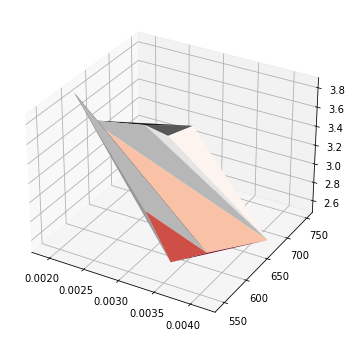

In [267]:
plt.set_cmap('Purples')


x = baseline_data.angularity
y = baseline_data.weight
#x,y = np.meshgrid(x,y)
z = baseline_data.BCS
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')

#ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(x,y,z,cmap = 'RdGy')
plt.show()

In [247]:
X = np.c_[(baseline_data.angularity)*1000,(baseline_data.weight)/1000]
print(X)
#Z  = fit(X,baseline_data.BCS)
#X1 = baseline_data.angularity*1000
Z = fit(X,baseline_data.BCS)
print(Z)

[[4.1688314  0.68      ]
 [3.78100845 0.601     ]
 [3.6340086  0.544     ]
 [2.91771637 0.6       ]
 [2.65541897 0.75      ]
 [2.66542925 0.69      ]
 [2.42535512 0.675     ]
 [1.94536415 0.63      ]
 [1.90223091 0.603     ]]
(array([ 0.        , -1.38195486, -4.73087383,  0.16347451, -0.22547776,
        4.09651876]), 7.38853403054756)


In [248]:
poly = PolynomialFeatures(2)
XX = poly.fit_transform([X[0]])
np.dot(XX,Z[0])+Z[1]

array([2.50649664])

In [249]:
BCS_data = pd.read_excel('BCS & Weights from 21Jul21.xlsx',sheet_name = 'BCS')
Weight_data = pd.read_excel('BCS & Weights from 21Jul21.xlsx',sheet_name = 'Body Weights')
test_dir = 'C:/Users/BOZ/Zoetis_BCS/1+2_selected/'
#test_dir = 'C:/Users/BOZ/Zoetis_BCS/BCS_estimation/3D_rolling_ball/test_set/'
ave_error, qualify, Results = rolling_ball(test_dir,BCS_data,Weight_data,Z,disk,replace,err_range=0.5)

In [250]:
print("average score error:",format(ave_error,'.3f'))
print("percentage of predictions whose errors lower than 0.5:",format(qualify,'.2%'))

average score error: 0.274
percentage of predictions whose errors lower than 0.5: 85.41%


In [251]:
writer = pd.ExcelWriter('rolling_ball_finalversion.xlsx')
Results.to_excel(writer,'results')
writer.save()
writer.close()

C:\Users\BOZ\Anaconda3\lib\site-packages\xlsxwriter\workbook.py:336: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


In [252]:
class_names = ['2.5','2.75','3.0','3.25','3.5','3.75','4.0']
cm = confusion_matrix(Results.round_BCS,Results.round_labels)

<ipython-input-253-42da911b7ea2>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
<ipython-input-253-42da911b7ea2>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


Text(0, 0.5, 'Predicted BCS')

<Figure size 432x288 with 0 Axes>

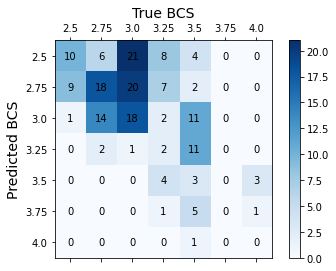

In [253]:
plt.set_cmap('Blues')
alpha = ['2.5','2.75','3.0','3.25','3.5','3.75','4.0']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, interpolation='nearest')
fig.colorbar(cax)
data_conf = cm
for (i, j), z in np.ndenumerate(data_conf):
    ax.text(j, i, '{}'.format(z), ha='center', va='center')
    # axis formatting 

ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)
plt.title("True BCS".format(" "*18), fontsize=14)
plt.ylabel("Predicted BCS".format(" "*18), fontsize=14)

In [264]:
#read our final estimation result
df = pd.read_excel('rolling_ball_finalversion.xlsx')
df = df[['round_labels','estimated_BCS']]
df

,round_labels,estimated_BCS
0,3.25,2.460
1,3.25,2.566
2,3.25,2.466
3,3.25,2.537
4,3.25,2.713
...,...,...
180,3.50,3.561
181,3.50,3.529
182,3.50,3.477
183,3.50,3.299


In [259]:
X1 = Results.round_labels
Y1 = Results.estimated_BCS
c1 = np.abs(X1-Y1)
c1 = round(c1*4)/4
mean_squared_error(X1,Y1)

0.1360621027027027

Text(0, 0.5, 'Predicted BCS')

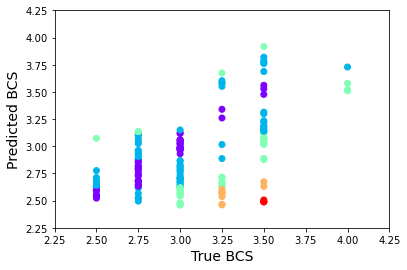

In [261]:
from matplotlib.pyplot import MultipleLocator
plt.scatter(X1,Y1,c=c1,cmap='rainbow')
x_major_locator=MultipleLocator(0.25)
y_major_locator=MultipleLocator(0.25)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlim(2.25,4.25)
plt.ylim(2.25,4.25)
plt.xlabel("True BCS".format(" "*18), fontsize=14)
plt.ylabel("Predicted BCS".format(" "*18), fontsize=14)

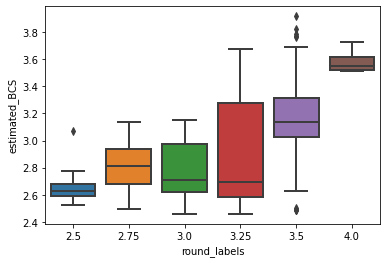

In [266]:
ax = sns.boxplot(x="round_labels", y="estimated_BCS",
                 data = df, linewidth=2)